<a href="https://colab.research.google.com/github/Rits396/Self_Learning_Comment_Analysis/blob/main/SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SENTIMENT ANALYSIS OF AMAZON'S CUSTOMER REVIEWS

We'll be doing the following in this case:

1)Read and analyze the input text data and the corresponding response variables (ratings)

2)Perform basic pre-processing to prepare the data for modeling

3)Learn and apply various ways of featurizing the reviews text

4)Build machine learning models to classify text as either exhibiting positive or negative sentiment (1 or 0).

In [ ]:
#General packages
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib as plt

#NLP packages
import nltk
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

Following attributes are available in our dataset :

1)**Id (numerical)**: start and end date of the attack in timestamp format.

2)**ProductId (categorical**): ID of the referenced product by the customer.

3)**UserId (categorical)**: registered user ID.

4)**ProfileName (text)**: registered user profile name.

5)**HelpfulnessNumerator (numerical)**: number of users who found the review helpful.

6)**HelpfulnessDenominator (numerical)**: Number of users who voted whether the review was helpful or not.

7)**Score (ordinal)**: rating between 1 and 5.

8)**Time (numerical)**: timestamp of the review.

9)**Summary (text)**: brief summary of the review.

10)**Text (text)**: text of the review.

In [ ]:
amazon_reviews = pd.read_csv('https://media.githubusercontent.com/media/juliandariomirandacalle/NLP_Notebooks/master/01-Introduction_NLP/Customer_Reviews.csv')
print("NUMBER OF COLUMNS AND ROWS IN OUR DATESET ARE: ",amazon_reviews.shape,"\n\n\n\n")
amazon_reviews.sample(10)

NUMBER OF COLUMNS AND ROWS IN OUR DATESET ARE:  (10000, 9) 






,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
4268,B004391DK0,A1SS2SBDCGS4KD,Margaret,0,0,5,1294531200,Best Pizza since I have been gluten free,I absolutely LOVE this product - being able to...
8660,B003VXFK44,A25SQ33WVST1HV,Brant L. Rusch,0,1,2,1327708800,Not a fan of this blend,Coffee is a very subjective thing. Some peopl...
4748,B00139TT72,A1WKN1EOXSER0D,"Mom 2 Two ""wife2abadge""",1,2,5,1266796800,(apparently) delicious and healthy,I have started buying a lot of organic food ov...
3246,B005K4Q1VI,A2H84V55USFJQX,M5,0,0,5,1337126400,the best chocolate taste out there!,"the greatest, best chocolate taste in any keur..."
136,B002SRYRE8,A198FU6P1BVUNZ,Sarah,0,0,5,1349740800,Tastes awesome & looks beautiful,The BEST investment I've ever made for ginger....
1377,B00068PCTU,A3B4KVOTQT9TII,"S. Harlow ""Princess""",1,1,5,1269648000,Get Healthy Live Better and Longer,"Cutting sugar out of our diet,we went to splen..."
6378,B0046HLQ42,A2AR2MTI4T1Z30,customer,1,1,1,1334188800,HUGE RIPOFF,This says 4 pack...so I assumed like other pur...
2024,B001E5E29A,A1TP9URWVDW3N,William Houston,3,4,5,1256169600,Great Waffle Mix,This mix makes great tasting waffles. A littl...
6329,B001AW9PTO,A2OEZIIK61GDW0,California Doug,3,3,4,1280707200,Good stuff,These beef jerky strips are really good. Text...
165,B003TQQKFQ,A2TUJ3MOKXZVYK,Amy,1,1,5,1338508800,This stuff is sooooo good!,I read about pomegranate molasses so I had to ...


BASIC CLEANING

In [ ]:
#removing all null values
amazon_reviews= amazon_reviews[~amazon_reviews['Text'].isnull()]
print(amazon_reviews.isnull().sum())

#removing all duplicate values on the basis of userid , profilename,time etc
amazon_reviews=amazon_reviews.sort_values('ProductId').drop_duplicates(subset=['UserId','ProfileName','Time','Summary','Text'],keep='first',inplace=False)
amazon_reviews=amazon_reviews[amazon_reviews['HelpfulnessDenominator']>=amazon_reviews['HelpfulnessNumerator']]
amazon_reviews.shape


ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


(9520, 9)

CLASSIFYING REVIEWS AS POSITIVE (1) AND NEGATIVE (0)

In [ ]:
amazon_reviews['Score'].value_counts()


5    5933
4    1356
1     884
3     797
2     550
Name: Score, dtype: int64

In [ ]:
import warnings
warnings.filterwarnings("ignore")

For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the follow rule:


Ratings of 4 or 5 will get mapped to 1 and will be reltead to positive reviews

Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews

Ratings of 3 will get removed since they will represent neutral reviews.


number of neutral reviews which have been deleted:  797 

1    7289
0    1434
Name: Sentiment_rating, dtype: int64


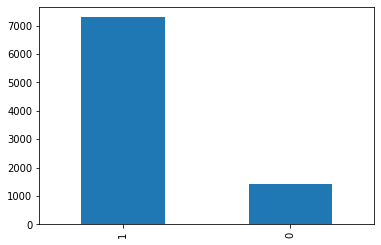

In [ ]:
x=(amazon_reviews["Score"].count())
## Removing neutral reviews
amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]
print("number of neutral reviews which have been deleted: ",x-(amazon_reviews.Score.count()),"\n")

# Mapping the ratings
amazon_reviews['Sentiment_rating'] = np.where(amazon_reviews.Score > 3,1,0)


# Printing the counts of each class
print(amazon_reviews['Sentiment_rating'].value_counts())

import matplotlib.pyplot as plt
amazon_reviews.Sentiment_rating.value_counts().plot.bar()
plt.show()


PRE-PROCESSING

1. CONVERTING REVIEWS TEXT TO LOWERCASE

In [ ]:
#. Converting words to lower case
amazon_reviews['reviews_text_new'] = amazon_reviews['Text'].str.lower()


In [ ]:
nltk.download("punkt")
# For reviews not converted to lower case
token_lists = [word_tokenize(each) for each in amazon_reviews['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lower case
token_lists_lower = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Number of unique tokens then:  27899
Number of unique tokens now:  22865


2. REMOVING SPECIAL CHARACTERS

In [ ]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = amazon_reviews['reviews_text_new'].apply(lambda review:
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)



In [ ]:
review_backup = amazon_reviews['reviews_text_new'].copy()
amazon_reviews['reviews_text_new'] = amazon_reviews['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')
print("A review for example without speical words(taken from reviews_text_new:\n",amazon_reviews.reviews_text_new[0])


A review for example without speical words(taken from reviews_text_new:
 i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 


3. STOPWORDS AND HIGH/LOW FREQUENCY WORDS

In [ ]:

from nltk.corpus import stopwords
noise_words = []
eng_stop_words = stopwords.words('english')


stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = amazon_reviews['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)





-- Original Sentence --
 i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 

-- Stopwords in the sentence --
 ['i', 'have', 'of', 'the', 'and', 'have', 'them', 'all', 'to', 'be', 'of', 'the', 'more', 'a', 'than', 'a', 'and', 'it', 'my', 'is', 'and', 'she', 'this', 'than', 'most']

-- Non-stopwords in the sentence --
 ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


In [ ]:
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

amazon_reviews['reviews_text_nonstop'] = amazon_reviews['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
amazon_reviews[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
2774,we have used the victor fly bait for 3 seasons...,"[used, victor, fly, bait, 3, seasons, beat, gr..."
2773,why is this when the same product is availab...,"[product, available, br, http, www, amazon, co..."
1243,i just received my shipment and could hardly w...,"[received, shipment, could, hardly, wait, try,..."
1244,this was a really good idea and the final prod...,"[really, good, idea, final, product, outstandi..."
9524,if you re new to this product you need to be v...,"[new, product, need, careful, dosage, strong, ..."
...,...,...
764,this is one of the best choices in my opinion...,"[one, best, choices, opinion, also, adore, ama..."
765,i have tried about 75 of the available t disc...,"[tried, 75, available, discs, kona, blend, one..."
767,of all the coffee s available for tassimo this...,"[coffee, available, tassimo, kona, richest, fl..."
1477,this coffee supposedly is premium it tastes w...,"[coffee, supposedly, premium, tastes, watery, ..."


STEMMING AND LEMMETIZATION

In [ ]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def stemm_terms(row):
    return [lancaster.stem(term) for term in row]
def lemmatize_terms(row):
    return [lemmatizer.lemmatize(term) for term in row]

amazon_reviews['reviews_text_stemm'] = amazon_reviews['reviews_text_nonstop'].apply(lambda row: stemm_terms(row))
amazon_reviews['reviews_text_lemm'] = amazon_reviews['reviews_text_nonstop'].apply(lambda row: lemmatize_terms(row))
amazon_reviews[['reviews_text_nonstop','reviews_text_stemm','reviews_text_lemm']]



BUILDING A MACHINE LEARNING MODEL

APPLYING LOGISTIC REGRESSION USING BAG OF WORDS

In [ ]:
# The following code creates a word-document matrix.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(amazon_reviews['reviews_text_new'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

In [ ]:
### Creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             stop_words=noise_words, # List of stopwords
                             ngram_range=(1,1)) # number of n-grams

bow_data = bow_counts.fit_transform(amazon_reviews['reviews_text_new'])
bow_data

<8723x18039 sparse matrix of type '<class 'numpy.int64'>'
	with 474236 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    amazon_reviews['Sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [ ]:
y_test_bow.value_counts()/y_test_bow.shape[0]

1    0.834384
0    0.165616
Name: Sentiment_rating, dtype: float64

In [ ]:
### Training the model
lr_model_all = LogisticRegression() # Logistic regression
lr_model_all.fit(X_train_bow, y_train_bow) # Fitting a logistic regression model

## Predicting the output
test_pred_lr_all = lr_model_all.predict(X_test_bow) # Class prediction



EVALUATING THE MODEL

1    1456
0     289
Name: Sentiment_rating, dtype: int64


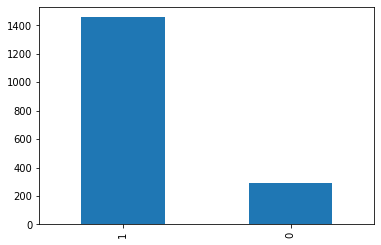

In [ ]:
#ACTUAL SENTIMENTS
import matplotlib.pyplot as plt
ser = pd.Series(y_test_bow)
print(ser.value_counts())
ser.value_counts().plot.bar()
plt.show()

1    1514
0     231
dtype: int64


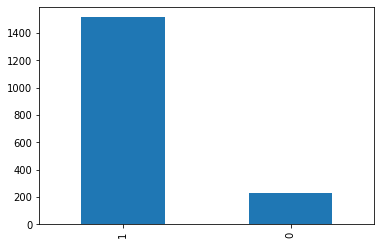

In [ ]:
#PREDICTED SENTIMENTS
import matplotlib.pyplot as plt
ser = pd.Series(test_pred_lr_all)
print(ser.value_counts())
ser.value_counts().plot.bar()
plt.show()

In [ ]:
## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print('Precision: %.3f' % precision_score(y_test_tfidf,test_pred_lr_all))
print('Recall: %.3f' % recall_score(y_test_tfidf,test_pred_lr_all))
print('Accuracy: %.3f' % accuracy_score(y_test_tfidf,test_pred_lr_all))

F1 score:  0.936026936026936
Precision: 0.918
Recall: 0.955
Accuracy: 0.891


In [ ]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # ge tall the n-gram feature names
                                   lr_model_all.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

lr_weights.sort_values(['weights'], ascending = False)[:15] # top-15 more important features for positive reviews

,words,weights
11750,perfect,1.868954
2065,best,1.706608
1007,amazing,1.622003
4697,delicious,1.541110
7393,great,1.539018
5994,excellent,1.528014
14684,smooth,1.474561
10797,nice,1.452033
12032,pleased,1.434054
7886,highly,1.384688


In [ ]:
lr_weights.sort_values(['weights'], ascending = False)[-15:] # top-15 more important features for negative reviews

,words,weights
10580,mushy,-1.240478
2849,cans,-1.245371
16051,terrible,-1.263497
8433,ingredient,-1.285515
16196,thought,-1.320993
10291,miss,-1.330503
7465,grounds,-1.389290
17813,worst,-1.447968
17469,weak,-1.549636
13478,return,-1.574587


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm=confusion_matrix(y_test_bow,test_pred_lr_all)
print(cm)

[[ 165  124]
 [  66 1390]]


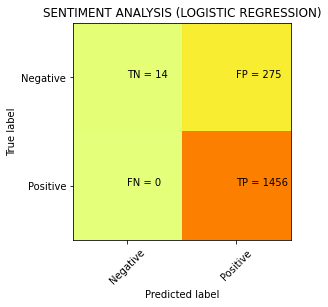

In [ ]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('SENTIMENT ANALYSIS (LOGISTIC REGRESSION)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

APPLYING RANDOM FOREST USING TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(amazon_reviews['reviews_text_new'])
tfidf_data

<8723x22865 sparse matrix of type '<class 'numpy.float64'>'
	with 506429 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            amazon_reviews['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

In [ ]:
 from sklearn.metrics import precision_score,recall_score
### Setting up the model class
lr_model_tf_idf = RandomForestClassifier()

## Training the model
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Prediciting the results
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)



F1 score:  0.9122807017543859
Precision: 0.839
Recall: 1.000
Accuracy: 0.840


EVALUATING THE MODEL

In [ ]:
## Evaluating the model
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print('Precision: %.3f' % precision_score(y_test_tfidf,test_pred_lr_all))
print('Recall: %.3f' % recall_score(y_test_tfidf,test_pred_lr_all))
print('Accuracy: %.3f' % accuracy_score(y_test_tfidf,test_pred_lr_all))

F1 score:  0.936026936026936
Precision: 0.918
Recall: 0.955
Accuracy: 0.891


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm=confusion_matrix(y_test_tfidf,test_pred_lr_all)
print(cm)

[[  14  275]
 [   0 1456]]


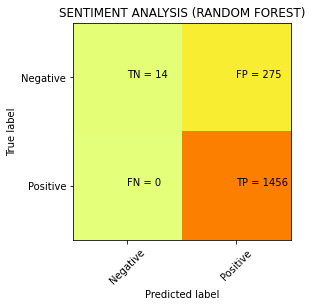

In [ ]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('SENTIMENT ANALYSIS (RANDOM FOREST)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()